<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/%EB%B9%84%EC%84%A0%ED%98%95%EC%84%B1%EC%97%90_%EB%8C%80%ED%95%9C_%EC%9D%B4%ED%95%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비선형성
비선형성이란 무엇일까? 우리는 activation function을 사용해 딥러닝 모델의 표현에 비선형성을 부여한다. universal approximation theroem에 따르면 노드의 출력을 비선형적인 함수에 통과시키는 간단한 프로세스는 단 하나의 히든레이어만으로도 모든 복잡한 함수를 근사할 수 있는 마법과도 같은 작용을 일으킨다.

 이번 프로젝트는 시그모이드함수를 activation function으로 사용하는 MLP모델의 학습정체의 원인이 vanishing gradient때문인지 아니면 깊이 증가에 따른 비선형성 증가로 모델이 local optima로 수렴했기 때문인지 탐구하고, 최종적으로 비선형성에대해 깊이 이해하는것을 목적으로 한다.

# 분석 과정

1. 각 층의 레이어의 weight가 loss에 주는 변화 분석
2. 같은 층의 weight 2개의 변화와 그에따른 loss변화의 3d그래프 분석
3. 깊은 층의 weight 2개의 변화와 그에따른 loss변화로 그린 3d그래프가 얕은층의 weight값 변화에따라 어떻게 변하는지 분석.

# Data와 Model, 분석에 필요한 메서드 작성

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

data

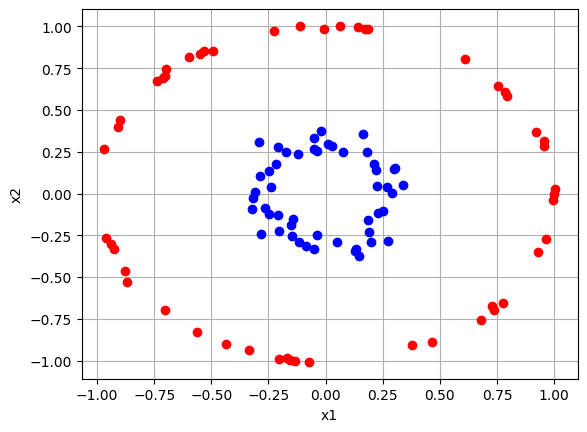

In [5]:
N=100
radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)
theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
class1_data=torch.hstack([radius1*torch.cos(theta1), radius1*torch.sin(theta1)])
class2_data=torch.hstack([radius2*torch.cos(theta2), radius2*torch.sin(theta2)])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
data=torch.vstack([class1_data,class2_data])
label=torch.vstack([class1_label,class2_label])

plt.plot(class1_data[:,0],class1_data[:,1],'bo')
plt.plot(class2_data[:,0],class2_data[:,1],'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

activation function으로 sigmoid를 사용하며 5개의 히든레이어를 갖는 MLP모델

In [6]:
class Sigmoid_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(2, 10), nn.Sigmoid(),
                                   nn.Linear(10, 10), nn.Sigmoid(),
                                   nn.Linear(10, 10), nn.Sigmoid(),
                                   nn.Linear(10, 10), nn.Sigmoid(),
                                   nn.Linear(10, 10), nn.Sigmoid(),
                                   nn.Linear(10, 10), nn.Sigmoid(),
                                   nn.Linear(10, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.layer(x)
        return x

activation function으로 relu를 사용하며 5개의 히든레이어를 갖는 MLP모델

In [7]:
class ReLU_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(2, 10), nn.ReLU(),
                                   nn.Linear(10, 10), nn.ReLU(),
                                   nn.Linear(10, 10), nn.ReLU(),
                                   nn.Linear(10, 10), nn.ReLU(),
                                   nn.Linear(10, 10), nn.ReLU(),
                                   nn.Linear(10, 10), nn.ReLU(),
                                   nn.Linear(10, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.layer(x)
        return x

Graph 메서드

In [72]:
def Graph_2D(model, layer_idx:int, wr:int, wc:int, scale:float, interval:int):
    wv = model.layer[layer_idx].weight[wr,wc].tolist()
    r = torch.linspace(wv-scale,wv+scale, interval)

    Loss = []
    for i in r:
        model.layer[layer_idx].weight.requires_grad = False
        model.layer[layer_idx].weight[wr,wc] = i
        model.layer[layer_idx].weight.requires_grad = True
        loss = F.binary_cross_entropy(model(data[0]), label[0])
        Loss.append(loss.tolist())

    return r, Loss

def Graph3D(model, layer_idx1:int, layer_idx2:int, wr1:int, wc1:int, wr2:int, wc2:int, scale1:float, scale2:float, interval:int):

    wv1 = model.layer[layer_idx1].weight[wr1,wc1].tolist()
    b1 = torch.linspace(wv1-scale1,wv1+scale1,interval)
    wv2 = model.layer[layer_idx2].weight[wr2,wc2].tolist()
    b2 = torch.linspace(wv2-scale2,wv2+scale2,interval)

    b1_test, b2_test = torch.meshgrid(b1,b2)

    Loss = []
    ct = 0

    for bi in b1:
        for bj in b2:
            model.layer[layer_idx1].weight.requires_grad = False
            model.layer[layer_idx1].weight[wr1,wc1] = bi
            model.layer[layer_idx1].weight.requires_grad = True
            model.layer[layer_idx2].weight.requires_grad = False
            model.layer[layer_idx2].weight[wr2,wc2] = bj
            model.layer[layer_idx2].weight.requires_grad = True
            loss = F.binary_cross_entropy(model(data[5]), label[5])
            Loss.append(loss.item())

    Loss = torch.tensor(Loss)
    Loss = Loss.reshape(interval,interval)
    Loss = Loss.T

    plt.figure(figsize=[10, 9])
    ax = plt.axes(projection="3d")
    ax.view_init(elev=25,azim=-140)
    ax.plot_surface(b1_test, b2_test, Loss, cmap="viridis", alpha=0.2)

    plt.xlabel("x1")
    plt.ylabel("x2")

    return b1_test, b2_test, Loss

3D graph animation

In [9]:
# # 변수 초기화
# N = 100  # 메쉬 그리드 수
# fps = 30  # 초당 함수 호출 빈도
# frn = 100  # 프레임 수
# layer_idx1 = 2
# layer_idx2 = 2
# layer_idx3 = 10
# wr1, wc1 = 2, 3
# wr2, wc2 = 4, 5
# wr3, wc3 = 2, 3
# scale1 = 0.1
# scale2 = 0.1
# scale3 = 0.1
# gap = 100

# # x, y, z 값 생성
# wv1 = s_model.layer[layer_idx1].weight[wr1,wc1].tolist()
# b1 = torch.linspace(wv1-scale1,wv1+scale1,gap)
# wv2 = s_model.layer[layer_idx2].weight[wr2,wc2].tolist()
# b2 = torch.linspace(wv2-scale2,wv2+scale2,gap)
# x, y = np.meshgrid(b1, b2)

# e = s_model.layer[layer_idx3].weight[wr3,wc3].tolist()
# e = torch.linspace(e-scale3,e+scale3,frn)

# # 초기화 함수
# def init():
#     ax.plot_surface(x, y, make_z_array(x, y, 0), cmap='viridis')

# # 갱신 함수
# def update_plot(frame, plot, ax):
#     ax.cla()  # 현재 플롯을 지움
#     z = make_z_array(x, y, frame)
#     plot = ax.plot_surface(x, y, z, cmap='viridis')
#     return plot

# # z 값을 만들기 위한 함수
# def make_z_array(x, y, t):

#     Loss = []
#     for bi in b1:
#         for bj in b2:
#             s_model.layer[layer_idx1].weight.requires_grad = False
#             s_model.layer[layer_idx1].weight[wr1,wc1] = bi
#             s_model.layer[layer_idx1].weight.requires_grad = True
#             s_model.layer[layer_idx2].weight.requires_grad = False
#             s_model.layer[layer_idx2].weight[wr2,wc2] = bj
#             s_model.layer[layer_idx2].weight.requires_grad = True
#             s_model.layer[layer_idx3].weight.requires_grad = False
#             s_model.layer[layer_idx3].weight[wr3,wc3] = e[t]
#             s_model.layer[layer_idx3].weight.requires_grad = True
#             loss = F.binary_cross_entropy(s_model(dX[5]), dy[5])
#             Loss.append(loss.item())

#     Loss = torch.tensor(Loss)
#     Loss = Loss.reshape(gap,gap)
#     Loss = Loss.T

#     return Loss

# # 새로운 피겨 및 서브플롯 생성
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # 애니메이션 클래스 호출
# plot = None
# animation = FuncAnimation(fig, update_plot, init_func=init, frames=frn, fargs=(plot, ax), interval=1000/fps)

# # Colab에서 애니메이션 표시
# from IPython.display import HTML
# html = animation.to_jshtml()
# HTML(html)

# 분석 1

이번 프로젝트의 시작은 sigmoid 함수를 activation function으로 사용하는 MLP모델의 학습정체의 원인을 분석하는것에서 시작한다. 원인은 vanishing gradient일까 아니면  local optima로의 수렴때문일까? 이것을 확인하기위해 깊은층의 레이어와 얕은층의 레이어의 weight값의 변화가 각각 loss값에 어떤 영향을 주는지 graph로 그려보자.

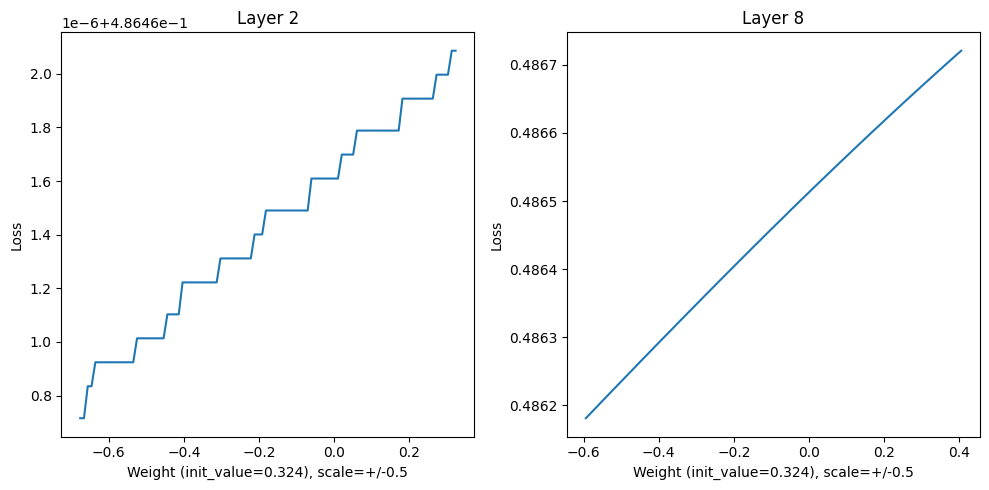

In [31]:
s_model = Sigmoid_model()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

r1, Loss1 = Graph_2D(s_model, layer_idx=2, wr=2, wc=3, scale=0.5, interval=100)
axs[0].plot(r1, Loss1)
axs[0].set_title('Layer 2')

r2, Loss2 = Graph_2D(s_model, layer_idx=8, wr=2, wc=3, scale=0.5, interval=100)
axs[1].plot(r2, Loss2)
axs[1].set_title('Layer 8')

for ax in axs:
    ax.set_ylabel('Loss')
    ax.set_xlabel(f'Weight (init_value={round(s_model.layer[2].weight[2, 3].item(), 3)}), scale=+/-0.5')

plt.tight_layout()

plt.show()

그래프에서 처음으로 관찰할 수 있는 차이는 비선형성이다. 깊은층의 레이어는 얕은층의 레이어보다 많은 activation function을 통과하게되고 상대적으로 더 큰 비선형성을 띄게 된다. 당연히 깊은층의 레이어는 얕은층의 레이어보다 local optima로 수렴할 확률이 훨씬 커지게 된다.

두번째로 관찰할 수 있는 것은 Loss값의 scale이다. 깊은층의 레이어와 얕은층의 레이어의 변화량은 +-0.5똑같지만 그에따른 Loss의 변화량은 큰차이가 있다. 깊은층의 레이어의 변화는 Loss에 거의 영향을 주지 못 하는 것 처럼 보인다. 이 또한 더 많은 activation function을 통과하기 때문이다. sigmoid의 경우 노드의 출력을 0~1사이로 rescale하므로 여러번 통과하게되면 최종적으로 결과값에 미치는 영향이 미미해지게 되는 것 이다. 이는 당연히 gradient값으로도 나타나게된다.

In [57]:
from torch import optim

s_model = Sigmoid_model()
s_model.train()
optimizer = optim.SGD(s_model.parameters(), lr=1e-1)
y_hat = s_model(data)
loss = F.binary_cross_entropy(y_hat, label)
optimizer.zero_grad()
loss.backward()

weight_norm = []

for i in range(0, 13, 2):
    w_norm = torch.sum(torch.abs(s_model.layer[i].weight.grad))

    weight_norm += [w_norm.item()]

print(f"2번째 레이어의 weight matrix의 nrom:{weight_norm[1]}")
print(f"8번째 레이어의 weight matrix의 nrom:{weight_norm[5]}")

2번째 레이어의 weight matrix의 nrom:2.2518885089084506e-05
8번째 레이어의 weight matrix의 nrom:0.14413851499557495


세번째로 관찰할 수 있는것은 방향성이다. 깊은층의 레이어는 분명 비선형성을 띄지만 분명히 어떤 방향성을 띄고 있다. 이것은 관찰을 위해 다른 weight값들과 bias값이 고정함으로써 나타나는 현상일 것 이다. 모든 매개변수가 함께 변하게되면 loss값에 영향을 거의 주지 못 하는 깊은층의 레이어가 그리는 그래프는 뱡향성을 갖지 못할 가능성이 크다. 반면 얕은층의 레이어는 모든 매개변수가 같이 변해도 방향성을 가질 가능성이 클 것 이다.

# 분석2

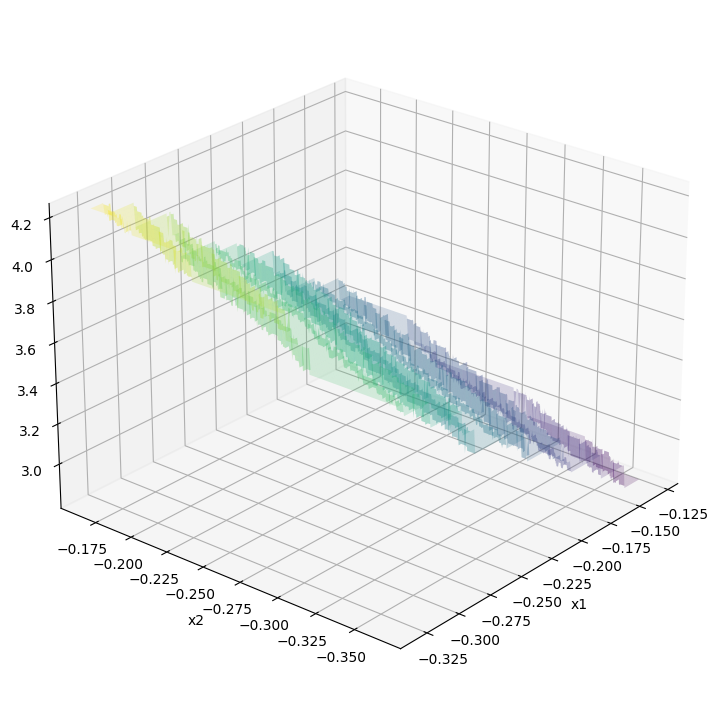

In [73]:
s_model = Sigmoid_model()
b1, b2, Loss = Graph3D(s_model, layer_idx1=2, layer_idx2=2, wr1=0, wc1=0, wr2=1, wc2=4, scale1=0.1, scale2=0.1, interval=200 )

In [74]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=b1, y=b2, z=Loss, colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='binary classification', width=700, height=600)